## Binary Image Classification

## Mount your Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My\ Drive/Colab\ Notebooks/
%ls

/gdrive/My Drive/Colab Notebooks
'2019_trials_index_v1 (1).xlsx'                    nextrad/
 classifier.ipynb                                  NeXtRAD.ini
 data/                                             PCA.ipynb
 el_dataflow_diagram                               PCA_kPCA.ipynb
 ensemble_learning                                 proc_config.ini
 feature_extraction.drawio                         Ref_Synth/
'GA Supervision Tracking Form-EEE4022-2020.xlsx'   transfer_learning_model


## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go
import pandas as pd
from random import sample 
from collections import Counter

In [4]:
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [5]:
import seaborn as sns
from prettytable import PrettyTable
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Image Classification
We will load the images as columns in the matrix $X$ and compute the SVD. What we will have are the eigen drones (orthonormal basis drones) in the matrix $U$. We will use the columns of $U$ to capture different features in the drone spectrogram data. 

Now if we have a test image $x$ no included in the original library that makes up $X$ we can project it into the eigen drone space of $U$ 

$$
\alpha = U_{r}^T x 
$$
the approximation of $x$
$$
\hat{x} = U_r \alpha
$$

in this eigen drone subspace. We can classify an unseen image by determining where it lies in the projected drone space.

## Load Images

In [6]:
IMG_SIZE = 64 # All images will be resized
SEED = 222
BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = 1000

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [7]:
A = tf.keras.preprocessing.image_dataset_from_directory(
  'nextrad/',
  label_mode='binary',
  color_mode="rgb",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 156 files belonging to 2 classes.


In [8]:
class_names = A.class_names
print(class_names)

['drone', 'nodrone']


In [9]:
X = []
Y = []

for images, labels in A.take(-1):
  X.append(images[0][:].numpy().astype("uint8"))
  Y.append(class_names[ int(labels[0][0]) ])

In [ ]:
X = np.array(X)
X = X.reshape(156, -1)
Y = np.array(Y)

## Visualise the data

Here are the first 8 examples

This is supposed to be a 'nodrone':


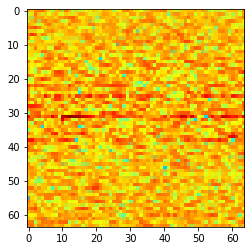

This is supposed to be a 'nodrone':


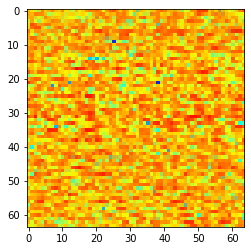

This is supposed to be a 'drone':


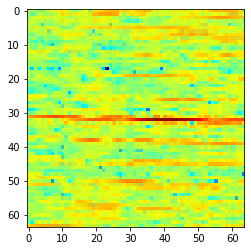

This is supposed to be a 'nodrone':


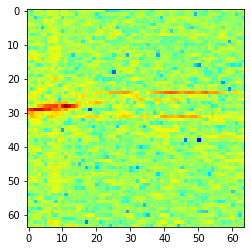

This is supposed to be a 'drone':


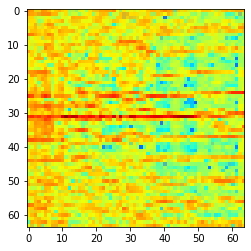

This is supposed to be a 'drone':


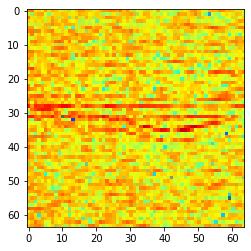

This is supposed to be a 'nodrone':


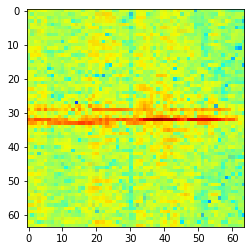

This is supposed to be a 'nodrone':


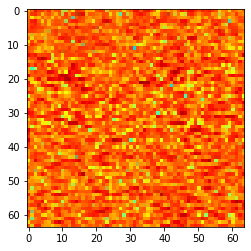

In [ ]:
# Let's look a a few examples
for i in range(8):  # show 8 examples 
  print("This is supposed to be a '",Y[i],"':",sep="")
  plt.imshow(X[i].reshape([IMG_SIZE, IMG_SIZE, 3]))
  plt.show()

## Projection the data
Produce a 'coordinate system' where different 'directions' decouple from each other. The system has its own eigen inherent set of orientations which are different the 'arbitrary' coordinates that we 'humans' may have assigned initially.

The numbers in that matrix are the covariances in the directions of the eigenvectors.

So really all we have to do is make a coordinate transformation using the matrix of eigenvectors, and then in order to project we'll literally just drop a whole index's-worth of data-dimension in this new coordinate system

In [ ]:
#W = vs[:, 0:3]  # just three dimensions

#project = X @ W

# Make the plot, separate them by "z" which is the digit of interest.  
#fig = go.Figure(data=[go.Scatter3d(x=project[:,0], y=project[:,1], z=project[:,2],
#                mode='markers', marker=dict(size=4, opacity=0.8, color=Y, showscale=True), 
# 
#                text = ['label=' + 'drone' if j == 1 else 'label=' + 'nodrone' for j in Y] )])
#fig.update_layout(title="Drones in component space", xaxis_title="q_1", yaxis_title="q_2", yaxis = dict(scaleanchor = "x",scaleratio = 1) )
#fig.show()

# Machine Learning Metrics

In [ ]:
def print_score(y_test, y_pred):  
  print("Test Result:\n===========================================")        
  print(f"accuracy score: {accuracy_score(y_test, y_pred)}\n")
  print(f"Classification Report: \n \tPrecision: {precision_score(y_test, y_pred)}\n\tRecall Score: {recall_score(y_test, y_pred)}\n\tF1 score: {f1_score(y_test, y_pred)}\n")

In [ ]:
def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(
            conf_matrix, index=class_names, columns=class_names, 
        )
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

In [ ]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

## Define a procedure for generating train and test sets

In [ ]:
# ML-Ensemble for this figure: you can install it with: pip install mlens
!pip install mlens

     |████████████████████████████████| 235kB 7.3MB/s 


In [ ]:
def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

## Define a library of base learners

In [ ]:
base_learners = get_models()

## Define a meta learner

In [ ]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED)

## Train the base learners on a training set

In [ ]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """
    Train all base learners in the library.
    """
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

## Generate base learner predictions

In [ ]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """
    Generate a prediction matrix.
    """
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

## Train the meta learner

In [ ]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """
    Generate predictions from the ensemble.
    """
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

## Training with cross-validation

In [ ]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    # print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    # print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    # print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        # print("Fold %i done" % (i + 1))

    # print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    # print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    # print("done")

    return base_learners, meta_learner

## Training and Testing on subsets of the training dataset 

In [ ]:
from sklearn.model_selection import KFold
def score_subset (size, X_test_prev, y_test_prev, meta_learner):
  # Split the training data
  X_train, _, y_train, _ = train_test_split(X_train_prev, y_train_prev, test_size=size)  

  # Convert y_train to NumPy array
  Y_num_train = []
  for j in y_train:
    if j == 'drone':
      Y_num_train.append(1)
    else: 
      Y_num_train.append(0)

  Y_num_train = np.array(Y_num_train)
  ytrain = pd.DataFrame(data=Y_num_train)
  ytrain = ytrain.values.reshape(Y_num_train.shape[0],)

  # Convert y_test to NumPy array
  Y_num_test = []
  for j in y_test_prev:
    if j == 'drone':
      Y_num_test.append(1)
    else: 
      Y_num_test.append(0)

  Y_num_test = np.array(Y_num_test)
  ytest = pd.DataFrame(data=Y_num_test)
  ytest = ytest.values.reshape(Y_num_test.shape[0],)

  # Train with stacking
  cv_base_learners, cv_meta_learner = stacking(
      get_models(), clone(meta_learner), X_train, ytrain, KFold(2))

  # Test with stacking
  P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, X_test_prev, verbose=False)

  return P_pred, p, roc_auc_score(ytest, p)

In [ ]:
import operator

def best_score (X_test_prev, y_test_prev, meta_learner):

  # Record scores
  scores = list()
  seg = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  for s in seg:
    P_pred, p, roc = score_subset (s, X_test_prev, y_test_prev, meta_learner)
    scores.append(roc)

  # Return the best score
  index, value = max(enumerate(scores), key=operator.itemgetter(1))
  return index, value

## Principal Component Analysis

In [ ]:
# Use the standard PCA for dimensionality reduction 
transformer = PCA(n_components=6,svd_solver='full') 
X_pca = transformer.fit_transform(X)

# Original data split for training and testing. Ratio 70:30
X_train_prev, X_test_prev, y_train_prev, y_test_prev = train_test_split(X_pca, Y, test_size=0.3, random_state=5)

# Scaling the data
sc = StandardScaler()
X_train_prev = sc.fit_transform(X_train_prev)
X_test_prev = sc.transform(X_test_prev)

In [ ]:
# Obtain the best score
index, values = best_score (X_test_prev, y_test_prev, meta_learner)

In [ ]:
# Index of the best score is at index + 1
print (f"Subset = {index+1} and roc = {values}")

Subset = 1 and roc = 1.0


=======================Standard PCA==========================

Ensemble ROC-AUC score: 0.989
Test Result:
accuracy score: 0.9574468085106383

Classification Report: 
 	Precision: 0.9
	Recall Score: 1.0
	F1 score: 0.9473684210526316



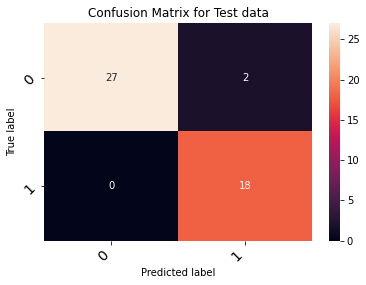

In [ ]:
print("=======================Standard PCA==========================")
# Print the metric for the best score 
P_pred, p, roc = score_subset ((index+1)/10.0, X_test_prev, y_test_prev, meta_learner)

ypred_pca = list(map(lambda x : 0 if x < 0.5e-01 else 1, p))
ypred_pca = np.array(ypred_pca)

# Convert y_test to NumPy array
Y_num_test = []
for j in y_test_prev:
  if j == 'drone':
    Y_num_test.append(1)
  else: 
    Y_num_test.append(0)

Y_num_test = np.array(Y_num_test)
ytest_pca = pd.DataFrame(data=Y_num_test)
ytest_pca = ytest_pca.values.reshape(Y_num_test.shape[0],)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest_pca, p))
print_score(ytest_pca, ypred_pca)
plot_conf_matrix(confusion_matrix(ytest_pca, ypred_pca), "Test data")

## Kernel Principal Component Analysis

=======================Linear Kernel PCA==========================
Subset = 1 and roc = 1.0

Ensemble ROC-AUC score: 0.989
Test Result:
accuracy score: 0.9787234042553191

Classification Report: 
 	Precision: 0.9473684210526315
	Recall Score: 1.0
	F1 score: 0.972972972972973



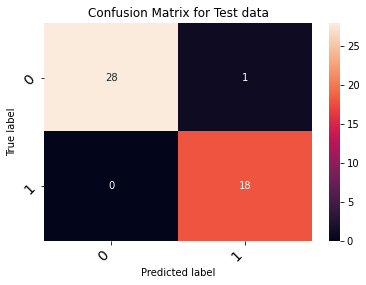

In [ ]:
print("=======================Linear Kernel PCA==========================")
transformer = KernelPCA(n_components=6, kernel='linear')
X_pca = transformer.fit_transform(X)

# Original data split for training and testing. Ratio 70:30
X_train_prev, X_test_prev, y_train_prev, y_test_prev = train_test_split(X_pca, Y, test_size=0.3, random_state=5)

# Scaling the data
sc = StandardScaler()
X_train_prev = sc.fit_transform(X_train_prev)
X_test_prev = sc.transform(X_test_prev)

# Obtain the best score
index, value = best_score (X_test_prev, y_test_prev, meta_learner)
# Index of the best score is at index + 1
print (f"Subset = {index+1} and roc = {value}")

# Print the metric for the best score 
P_pred, p, roc = score_subset ((index+1)/10.0, X_test_prev, y_test_prev, meta_learner)

ypred_lkpca = list(map(lambda x : 0 if x < 0.5e-01 else 1, p))
ypred_lkpca  = np.array(ypred_lkpca )

# Convert y_test to NumPy array
Y_num_test = []
for j in y_test_prev:
  if j == 'drone':
    Y_num_test.append(1)
  else: 
    Y_num_test.append(0)

Y_num_test = np.array(Y_num_test)
ytest_lkpca = pd.DataFrame(data=Y_num_test)
ytest_lkpca = ytest_lkpca.values.reshape(Y_num_test.shape[0],)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest_lkpca, p))
print_score(ytest_lkpca, ypred_lkpca)
plot_conf_matrix(confusion_matrix(ytest_lkpca, ypred_lkpca), "Test data")

=======================POLY Kernel PCA==========================
Subset = 2 and roc = 1.0

Ensemble ROC-AUC score: 0.996
Test Result:
accuracy score: 0.9574468085106383

Classification Report: 
 	Precision: 0.9
	Recall Score: 1.0
	F1 score: 0.9473684210526316



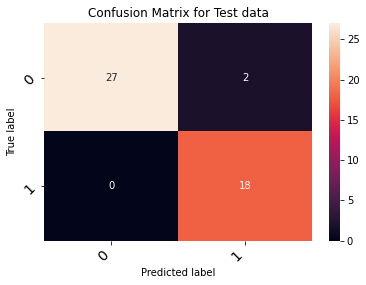

In [ ]:
print("=======================POLY Kernel PCA==========================")
transformer = KernelPCA(n_components=6, kernel='poly')
X_pca = transformer.fit_transform(X)

# Original data split for training and testing. Ratio 70:30
X_train_prev, X_test_prev, y_train_prev, y_test_prev = train_test_split(X_pca, Y, test_size=0.3, random_state=5)

# Scaling the data
sc = StandardScaler()
X_train_prev = sc.fit_transform(X_train_prev)
X_test_prev = sc.transform(X_test_prev)

# Obtain the best score
index, value = best_score (X_test_prev, y_test_prev, meta_learner)
# Index of the best score is at index + 1
print (f"Subset = {index+1} and roc = {value}")

# Print the metric for the best score 
P_pred, p, roc = score_subset ((index+1)/10.0, X_test_prev, y_test_prev, meta_learner)

ypred_pkpca = list(map(lambda x : 0 if x < 0.5e-01 else 1, p))
ypred_pkpca = np.array(ypred_pkpca)

# Convert y_test to NumPy array
Y_num_test = []
for j in y_test_prev:
  if j == 'drone':
    Y_num_test.append(1)
  else: 
    Y_num_test.append(0)

Y_num_test = np.array(Y_num_test)
ytest_pkpca = pd.DataFrame(data=Y_num_test)
ytest_pkpca = ytest_pkpca.values.reshape(Y_num_test.shape[0],)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest_pkpca, p))
print_score(ytest_pkpca, ypred_pkpca)
plot_conf_matrix(confusion_matrix(ytest_pkpca, ypred_pkpca), "Test data")

=======================Radial Kernel PCA==========================
Subset = 6 and roc = 0.6350574712643677

Ensemble ROC-AUC score: 0.575
Test Result:
accuracy score: 0.5957446808510638

Classification Report: 
 	Precision: 0.4782608695652174
	Recall Score: 0.6111111111111112
	F1 score: 0.5365853658536586



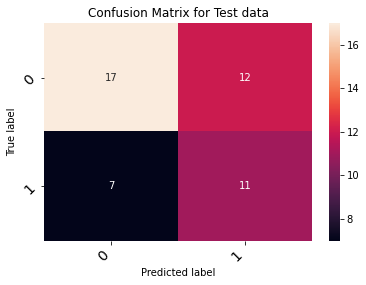

In [ ]:
print("=======================Radial Kernel PCA==========================")
transformer = KernelPCA(n_components=6, kernel='rbf')
X_pca = transformer.fit_transform(X)

# Original data split for training and testing. Ratio 70:30
X_train_prev, X_test_prev, y_train_prev, y_test_prev = train_test_split(X_pca, Y, test_size=0.3, random_state=5)

# Scaling the data
sc = StandardScaler()
X_train_prev = sc.fit_transform(X_train_prev)
X_test_prev = sc.transform(X_test_prev)

# Obtain the best score
index, value = best_score (X_test_prev, y_test_prev, meta_learner)
# Index of the best score is at index + 1
print (f"Subset = {index+1} and roc = {value}")

# Print the metric for the best score 
P_pred, p, roc = score_subset ((index+1)/10.0, X_test_prev, y_test_prev, meta_learner)

ypred_rbfkpca = list(map(lambda x : 0 if x < 0.5e-01 else 1, p))
ypred_rbfkpca = np.array(ypred_rbfkpca)

# Convert y_test to NumPy array
Y_num_test = []
for j in y_test_prev:
  if j == 'drone':
    Y_num_test.append(1)
  else: 
    Y_num_test.append(0)

Y_num_test = np.array(Y_num_test)
ytest_rbfkpca = pd.DataFrame(data=Y_num_test)
ytest_rbfkpca = ytest_rbfkpca.values.reshape(Y_num_test.shape[0],)

print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest_rbfkpca, p))
print_score(ytest_rbfkpca, ypred_rbfkpca)
plot_conf_matrix(confusion_matrix(ytest_rbfkpca, ypred_rbfkpca), "Test data")

## Dig Deeper into the Best Model

In [ ]:
print("=======================Standard PCA==========================")
fpr_pca, tpr_pca, thresholds_pca = roc_curve(ytest_pca, ypred_pca)
auc_pca = auc(fpr_pca, tpr_pca)

print("=======================Linear Kernel PCA==========================")
fpr_lkpca, tpr_lkpca, thresholds_lkpca = roc_curve(ytest_lkpca, ypred_lkpca)
auc_lkpca = auc(fpr_lkpca, tpr_lkpca)

print("=======================Poly Kernel PCA==========================")
fpr_pkpca, tpr_pkpca, thresholds_pkpca = roc_curve(ytest_pkpca, ypred_pkpca)
auc_pkpca = auc(fpr_pkpca, tpr_pkpca)

print("=======================Radial Kernel PCA==========================")
fpr_rbfkpca, tpr_rbfkpca, thresholds_rbfkpca = roc_curve(ytest_rbfkpca, ypred_rbfkpca)
auc_rbfkpca = auc(fpr_rbfkpca, tpr_rbfkpca)

=======================Standard PCA==========================
=======================Linear Kernel PCA==========================
=======================Poly Kernel PCA==========================
=======================Radial Kernel PCA==========================


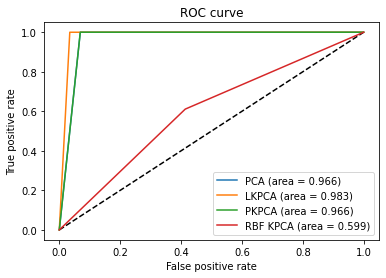

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_pca, tpr_pca, label='PCA (area = {:.3f})'.format(auc_pca))
plt.plot(fpr_lkpca, tpr_lkpca, label='LKPCA (area = {:.3f})'.format(auc_lkpca))
plt.plot(fpr_pkpca, tpr_pkpca, label='PKPCA (area = {:.3f})'.format(auc_pkpca))
plt.plot(fpr_rbfkpca, tpr_rbfkpca, label='RBF KPCA (area = {:.3f})'.format(auc_rbfkpca))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()